In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Optional: Style settings and warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [60]:
# Define the path to your CSV file
file_path = r"D:\New folder (2)\unified mentor project\customer_support_tickets.csv"

# Load the dataset
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("✅ Data Loaded Successfully!")
else:
    print("❌ File not found.")

# Clean the column names: lowercase, strip spaces, and replace spaces with underscores
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("\n✅ Cleaned Column Names:\n", df.columns.tolist())


✅ Data Loaded Successfully!

✅ Cleaned Column Names:
 ['ticket_id', 'customer_name', 'customer_email', 'customer_age', 'customer_gender', 'product_purchased', 'date_of_purchase', 'ticket_type', 'ticket_subject', 'ticket_description', 'ticket_status', 'resolution', 'ticket_priority', 'ticket_channel', 'first_response_time', 'time_to_resolution', 'customer_satisfaction_rating']


In [62]:
# Show basic info
print("🔍 Dataset Info:\n")
print(df.info())

# Check missing values
print("\n❓ Missing Values:\n")
print(df.isnull().sum())

# Convert datetime-related columns (if available)
# Note: We're only converting if the columns exist
datetime_cols = ['date_of_purchase', 'first_response_time', 'time_to_resolution']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print("\n✅ Date columns converted (if found).")


🔍 Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ticket_id                     8469 non-null   int64  
 1   customer_name                 8469 non-null   object 
 2   customer_email                8469 non-null   object 
 3   customer_age                  8469 non-null   int64  
 4   customer_gender               8469 non-null   object 
 5   product_purchased             8469 non-null   object 
 6   date_of_purchase              8469 non-null   object 
 7   ticket_type                   8469 non-null   object 
 8   ticket_subject                8469 non-null   object 
 9   ticket_description            8469 non-null   object 
 10  ticket_status                 8469 non-null   object 
 11  resolution                    2769 non-null   object 
 12  ticket_priority               8469 non-null  

In [68]:
# Convert datetime to duration in minutes from a reference point (like midnight)
df['first_response_minutes'] = df['first_response_time'].dt.hour * 60 + df['first_response_time'].dt.minute + df['first_response_time'].dt.second / 60
df['resolution_minutes'] = df['time_to_resolution'].dt.hour * 60 + df['time_to_resolution'].dt.minute + df['time_to_resolution'].dt.second / 60



In [70]:
# Drop high-cardinality and unused columns
df.drop(columns=[
    'ticket_id', 'customer_name', 'customer_email',
    'ticket_description', 'date_of_purchase',
    'first_response_time', 'time_to_resolution'
], inplace=True)

# Print updated columns
print("🧠 Feature Engineering Completed!\nColumns after transformation:\n", df.columns.tolist())


🧠 Feature Engineering Completed!
Columns after transformation:
 ['customer_age', 'customer_gender', 'product_purchased', 'ticket_type', 'ticket_subject', 'ticket_status', 'resolution', 'ticket_priority', 'ticket_channel', 'customer_satisfaction_rating', 'purchase_year', 'first_response_minutes', 'resolution_minutes']


In [72]:
from sklearn.impute import SimpleImputer

# Separate columns for imputation
impute_cols = df.select_dtypes(include=['object', 'float64', 'int64']).columns

# Imputer for both numeric and categorical: use most_frequent
imputer = SimpleImputer(strategy='most_frequent')
df_imputed_part = pd.DataFrame(imputer.fit_transform(df[impute_cols]), columns=impute_cols)

# Retain numeric calculated features not part of imputation
untouched_cols = df.drop(columns=impute_cols)
df_cleaned = pd.concat([df_imputed_part, untouched_cols], axis=1)

# Final check
print("🧼 Missing values handled. Final shape:", df_cleaned.shape)
print("📉 Still any nulls?\n", df_cleaned.isnull().sum())


🧼 Missing values handled. Final shape: (8469, 13)
📉 Still any nulls?
 customer_age                    0
customer_gender                 0
product_purchased               0
ticket_type                     0
ticket_subject                  0
ticket_status                   0
resolution                      0
ticket_priority                 0
ticket_channel                  0
customer_satisfaction_rating    0
first_response_minutes          0
resolution_minutes              0
purchase_year                   0
dtype: int64


In [74]:
# One-hot encode categorical variables
categorical_cols = df_cleaned.select_dtypes(include='object').columns

# Perform encoding
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

print("🧾 Encoding complete. New shape:", df_encoded.shape)


🧾 Encoding complete. New shape: (8469, 11083)


In [76]:
# Step 1: Limit high-cardinality columns to top 10 categories
high_card_cols = ['ticket_subject', 'product_purchased', 'resolution']

for col in high_card_cols:
    top_categories = df_cleaned[col].value_counts().nlargest(10).index
    df_cleaned[col] = df_cleaned[col].where(df_cleaned[col].isin(top_categories), other='Other')

# Step 2: Re-encode
df_encoded_reduced = pd.get_dummies(df_cleaned, columns=df_cleaned.select_dtypes(include='object').columns, drop_first=True)

print("✅ High-cardinality handled. Reduced shape:", df_encoded_reduced.shape)


✅ High-cardinality handled. Reduced shape: (8469, 8289)


In [80]:
print(df_encoded_reduced.columns.tolist())


['purchase_year', 'customer_age_19', 'customer_age_20', 'customer_age_21', 'customer_age_22', 'customer_age_23', 'customer_age_24', 'customer_age_25', 'customer_age_26', 'customer_age_27', 'customer_age_28', 'customer_age_29', 'customer_age_30', 'customer_age_31', 'customer_age_32', 'customer_age_33', 'customer_age_34', 'customer_age_35', 'customer_age_36', 'customer_age_37', 'customer_age_38', 'customer_age_39', 'customer_age_40', 'customer_age_41', 'customer_age_42', 'customer_age_43', 'customer_age_44', 'customer_age_45', 'customer_age_46', 'customer_age_47', 'customer_age_48', 'customer_age_49', 'customer_age_50', 'customer_age_51', 'customer_age_52', 'customer_age_53', 'customer_age_54', 'customer_age_55', 'customer_age_56', 'customer_age_57', 'customer_age_58', 'customer_age_59', 'customer_age_60', 'customer_age_61', 'customer_age_62', 'customer_age_63', 'customer_age_64', 'customer_age_65', 'customer_age_66', 'customer_age_67', 'customer_age_68', 'customer_age_69', 'customer_age

In [84]:
print(df_encoded_reduced.head())


   purchase_year  customer_age_19  customer_age_20  customer_age_21  \
0           2021            False            False            False   
1           2021            False            False            False   
2           2020            False            False            False   
3           2020            False            False            False   
4           2020            False            False            False   

   customer_age_22  customer_age_23  customer_age_24  customer_age_25  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   customer_age_26  customer_age_27  ...  resolution_minutes_1435.3  \
0            False            False  ...                      F

In [86]:
for col in df_encoded_reduced.columns:
    print(col)


purchase_year
customer_age_19
customer_age_20
customer_age_21
customer_age_22
customer_age_23
customer_age_24
customer_age_25
customer_age_26
customer_age_27
customer_age_28
customer_age_29
customer_age_30
customer_age_31
customer_age_32
customer_age_33
customer_age_34
customer_age_35
customer_age_36
customer_age_37
customer_age_38
customer_age_39
customer_age_40
customer_age_41
customer_age_42
customer_age_43
customer_age_44
customer_age_45
customer_age_46
customer_age_47
customer_age_48
customer_age_49
customer_age_50
customer_age_51
customer_age_52
customer_age_53
customer_age_54
customer_age_55
customer_age_56
customer_age_57
customer_age_58
customer_age_59
customer_age_60
customer_age_61
customer_age_62
customer_age_63
customer_age_64
customer_age_65
customer_age_66
customer_age_67
customer_age_68
customer_age_69
customer_age_70
customer_gender_Male
customer_gender_Other
product_purchased_Apple AirPods
product_purchased_Canon EOS
product_purchased_GoPro Hero
product_purchased_LG O

In [88]:
print(df_encoded_reduced.dtypes.value_counts())


bool     8288
int32       1
Name: count, dtype: int64


In [90]:
non_bool_cols = df_encoded_reduced.select_dtypes(exclude='bool').columns
print(non_bool_cols)


Index(['purchase_year'], dtype='object')


In [92]:
print(df.columns)


Index(['customer_age', 'customer_gender', 'product_purchased', 'ticket_type',
       'ticket_subject', 'ticket_status', 'resolution', 'ticket_priority',
       'ticket_channel', 'customer_satisfaction_rating', 'purchase_year',
       'first_response_minutes', 'resolution_minutes'],
      dtype='object')


In [94]:
# 1. Define target and features BEFORE encoding
y = df['customer_satisfaction_rating']
X = df.drop('customer_satisfaction_rating', axis=1)

# 2. One-hot encode only the features
X_encoded = pd.get_dummies(X)

# 3. Optional: Reduce encoded features if needed
# For example, you might be doing this step as part of feature selection
# X_encoded_reduced = some_feature_selection(X_encoded)

# 4. Split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("✅ Data split completed:")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)



✅ Data split completed:
Train shape: (6775, 2850)
Test shape: (1694, 2850)


In [98]:
# Combine features and target temporarily to drop rows with NaN target
train_data = pd.concat([X_train, y_train], axis=1)

# Drop rows where target (customer_satisfaction_rating) is NaN
train_data = train_data.dropna(subset=['customer_satisfaction_rating'])

# Split again
X_train_clean = train_data.drop(columns=['customer_satisfaction_rating'])
y_train_clean = train_data['customer_satisfaction_rating']



In [101]:
rf_model.fit(X_train_clean, y_train_clean)
y_pred = rf_model.predict(X_test)


In [105]:
y_pred = rf_model.predict(X_test)


In [109]:
# Check for missing values in y_test
print(y_test.isnull().sum())


1120


In [111]:
import pandas as pd

# Create a mask for non-null values
mask = y_test.notnull()

# Filter both y_test and y_pred
y_test_clean = y_test[mask]
y_pred_clean = pd.Series(y_pred, index=y_test.index)[mask]

# Now evaluate
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_clean, y_pred_clean)
print("Accuracy:", accuracy)


Accuracy: 0.20209059233449478


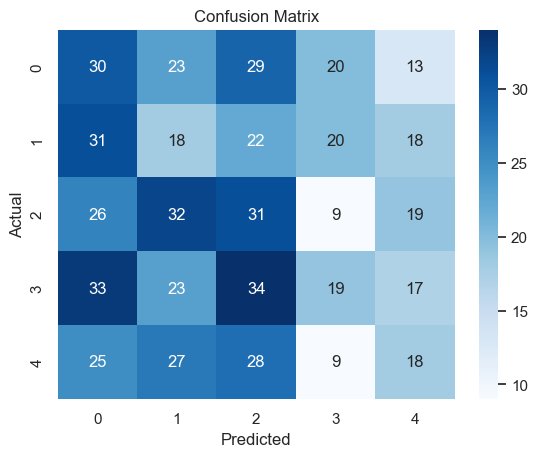

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_clean, y_pred_clean)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [115]:
report = classification_report(y_test_clean, y_pred_clean)
print(report)


              precision    recall  f1-score   support

         1.0       0.21      0.26      0.23       115
         2.0       0.15      0.17      0.16       109
         3.0       0.22      0.26      0.24       117
         4.0       0.25      0.15      0.19       126
         5.0       0.21      0.17      0.19       107

    accuracy                           0.20       574
   macro avg       0.21      0.20      0.20       574
weighted avg       0.21      0.20      0.20       574



In [117]:
print("Class distribution in y_test:")
print(y_test_clean.value_counts())


Class distribution in y_test:
customer_satisfaction_rating
4.0    126
3.0    117
1.0    115
2.0    109
5.0    107
Name: count, dtype: int64


In [121]:
# Combine X_train and y_train for joint filtering
train_df = X_train.copy()
train_df['target'] = y_train

# Drop rows where target is NaN
train_df = train_df.dropna(subset=['target'])

# Separate them back
X_train_clean = train_df.drop('target', axis=1)
y_train_clean = train_df['target']


In [128]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_clean, y_train_clean)
y_pred_rf = rf.predict(X_test)


In [131]:
y_train_filled = y_train.fillna(y_train.mode()[0])  # Replace with mode (most common value)


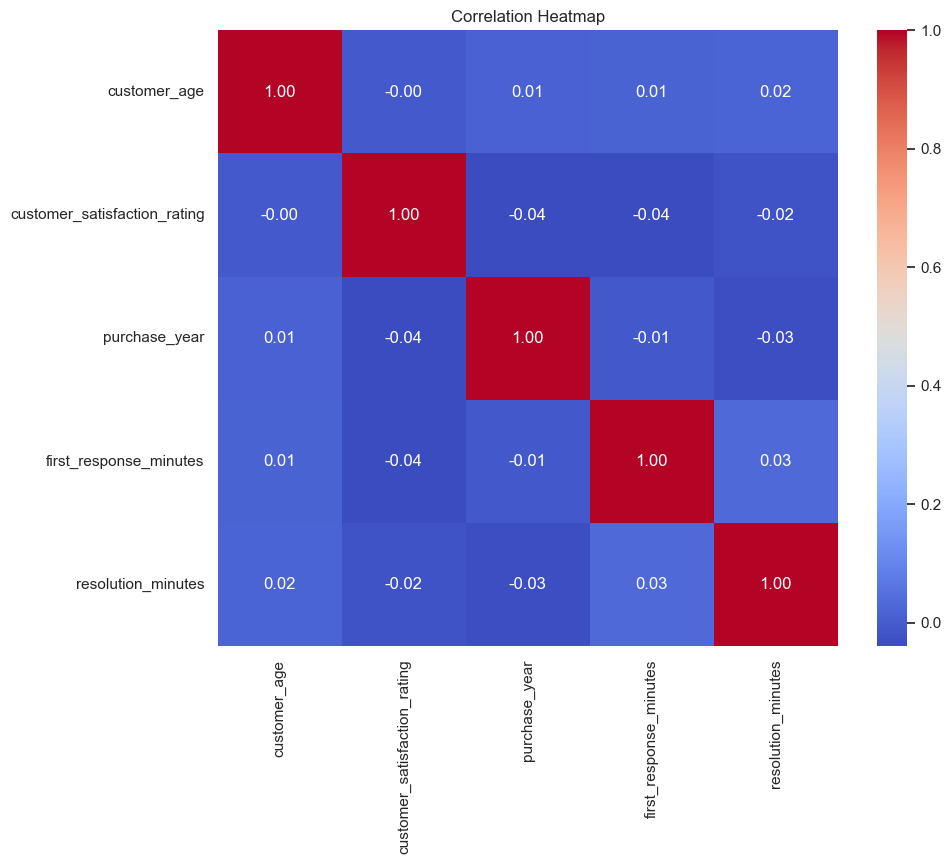

In [137]:
# Only select numeric columns for correlation matrix
numeric_df = df.select_dtypes(include='number')

# Now plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



In [141]:
# Encode categorical variables if any
X = pd.get_dummies(X)

# Scale features (optional, depending on the model)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Redo train-test split if scaling or encoding was applied
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [151]:
import numpy as np

# Identify rows without NaNs
mask = ~np.isnan(X_train).any(axis=1)

# Filter X_train and y_train
X_train = X_train[mask]
y_train = y_train[mask]



In [155]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)  # This step is required before predict()


LogisticRegression()

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [167]:
from sklearn.impute import SimpleImputer

# Create imputer and fit on training data
imputer = SimpleImputer(strategy='mean')  # You can change to 'median' or 'most_frequent' if needed
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the model again using imputed data
model.fit(X_train_imputed, y_train)

# Now predict
y_pred = model.predict(X_test_imputed)


In [179]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset indices to align them
X_train_df = X_train_df.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)



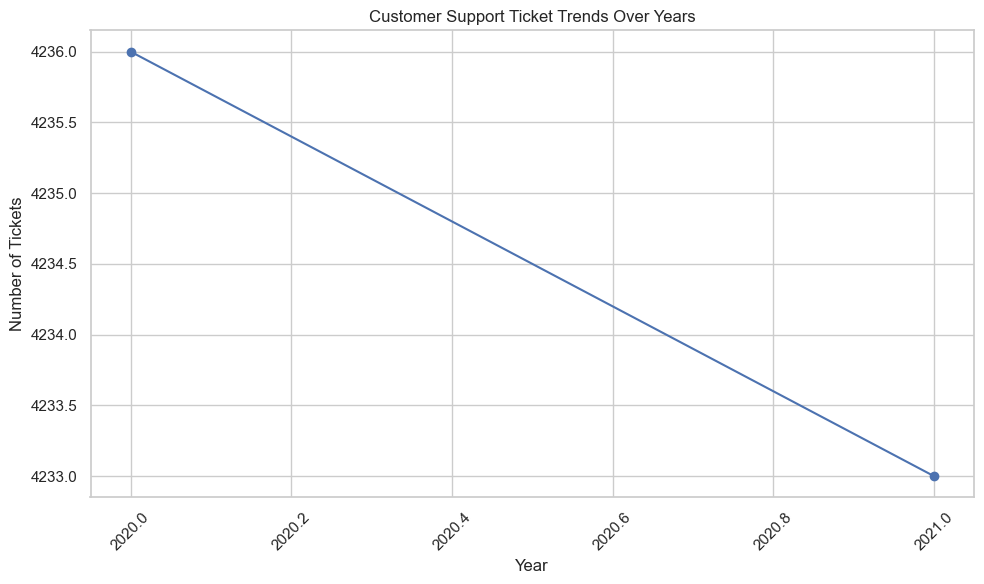

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by purchase_year and count tickets
ticket_trends = df.groupby('purchase_year').size()

# Plotting
plt.figure(figsize=(10, 6))
ticket_trends.plot(kind='line', marker='o')
plt.title('Customer Support Ticket Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Tickets')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





Segmentation based on Ticket Types:
ticket_type
Billing inquiry         1634
Cancellation request    1695
Product inquiry         1641
Refund request          1752
Technical issue         1747
dtype: int64

Segmentation based on Customer Satisfaction Levels:
customer_satisfaction_rating
1.0    553
2.0    549
3.0    580
4.0    543
5.0    544
dtype: int64


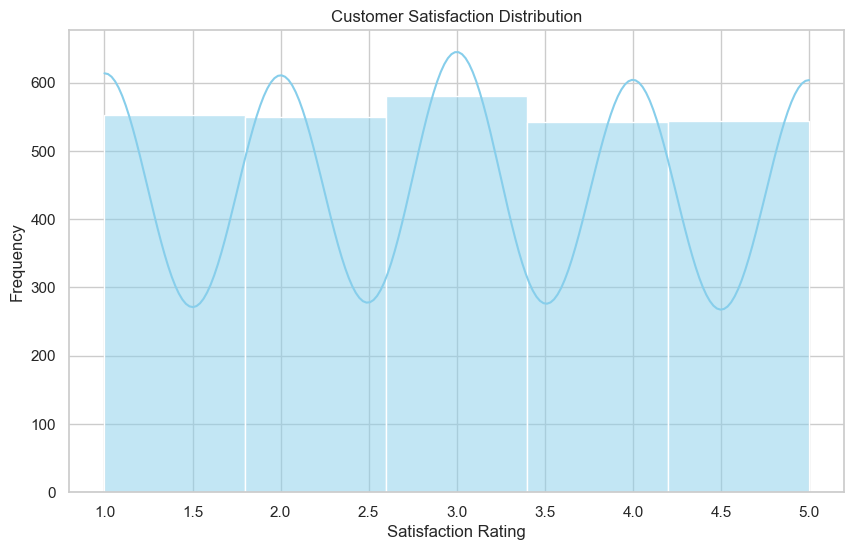

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Segment based on ticket types
ticket_type_segmentation = df.groupby('ticket_type').size()
print("\nSegmentation based on Ticket Types:")
print(ticket_type_segmentation)

# Segment based on customer satisfaction levels
satisfaction_segmentation = df.groupby('customer_satisfaction_rating').size()
print("\nSegmentation based on Customer Satisfaction Levels:")
print(satisfaction_segmentation)

# Set up the plotting aesthetics
sns.set(style="whitegrid")

# Plotting Customer Satisfaction Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['customer_satisfaction_rating'], bins=5, kde=True, color='skyblue')
plt.title('Customer Satisfaction Distribution')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Frequency')
plt.show()


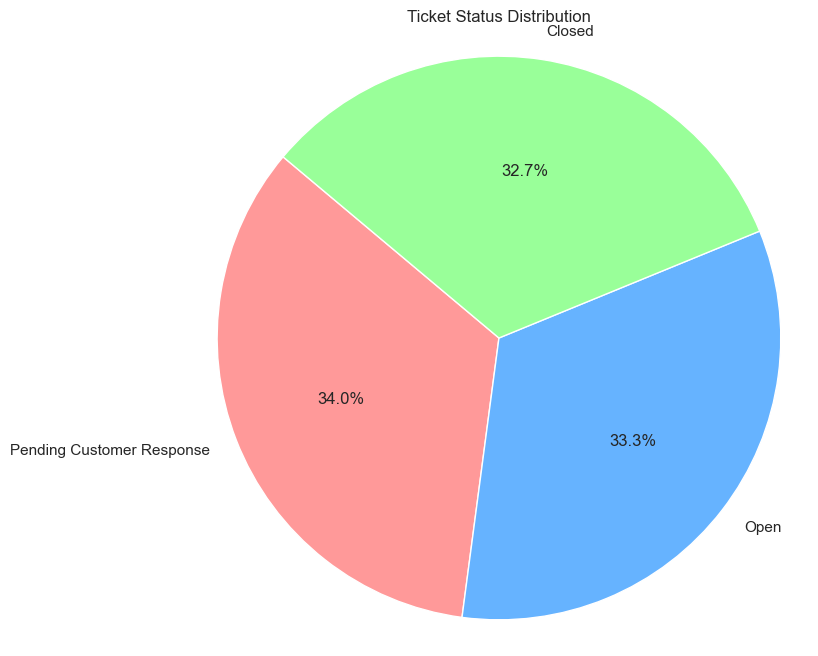

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors
custom_colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFD700', '#FFCCCB', '#B0E0E6']

# Ticket Status Distribution
ticket_status_distribution = df['ticket_status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(ticket_status_distribution,
        labels=ticket_status_distribution.index,
        autopct='%1.1f%%',
        colors=custom_colors[:len(ticket_status_distribution)],
        startangle=140)
plt.title('Ticket Status Distribution')
plt.axis('equal')
plt.show()


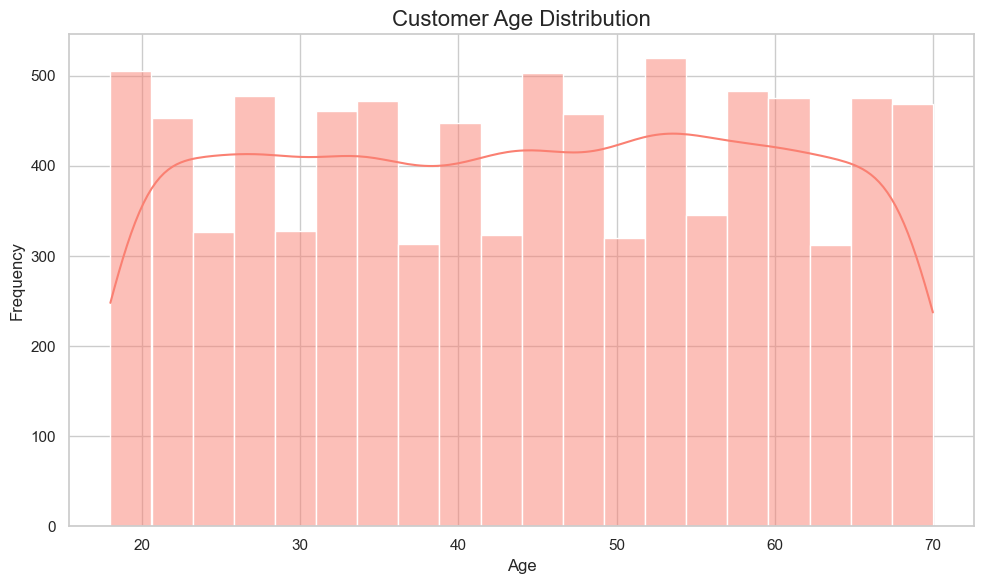

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the theme
sns.set(style="whitegrid")

# Plot: Customer Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['customer_age'], bins=20, kde=True, color='salmon')
plt.title('Customer Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


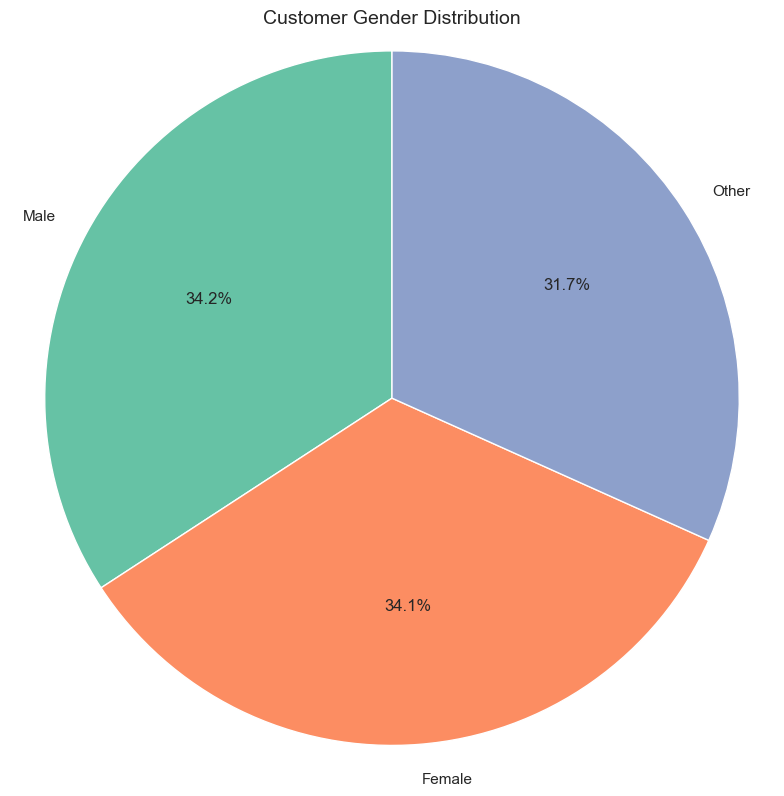

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gender distribution
customer_gender_distribution = df['customer_gender'].value_counts()

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    customer_gender_distribution,
    labels=customer_gender_distribution.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2'),
    startangle=90
)
plt.title('Customer Gender Distribution', fontsize=14)
plt.axis('equal')  # Ensures pie is a circle
plt.tight_layout()
plt.show()


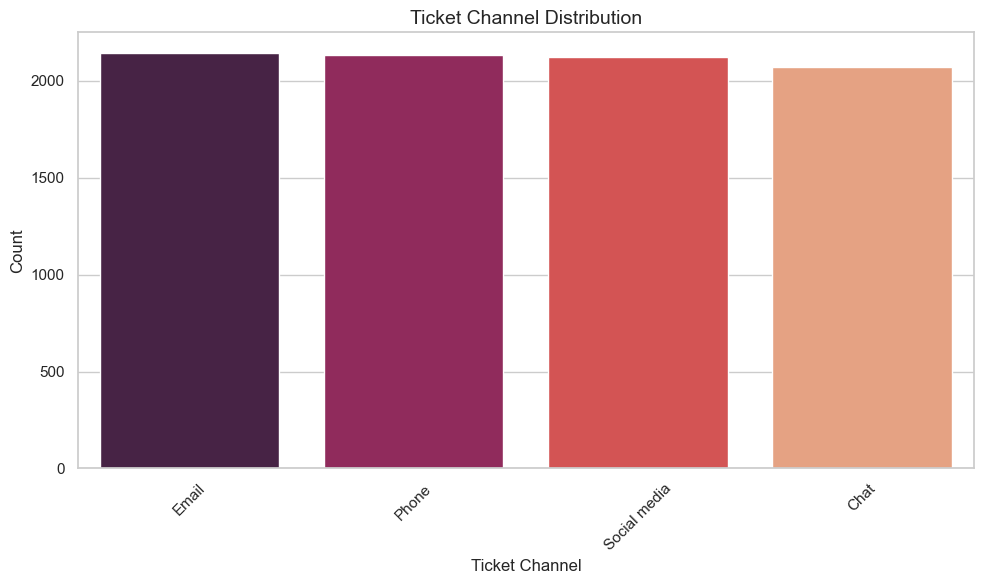

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
ticket_channel_distribution = df['ticket_channel'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ticket_channel_distribution.index,
    y=ticket_channel_distribution.values,
    palette='rocket'
)
plt.title('Ticket Channel Distribution', fontsize=14)
plt.xlabel('Ticket Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


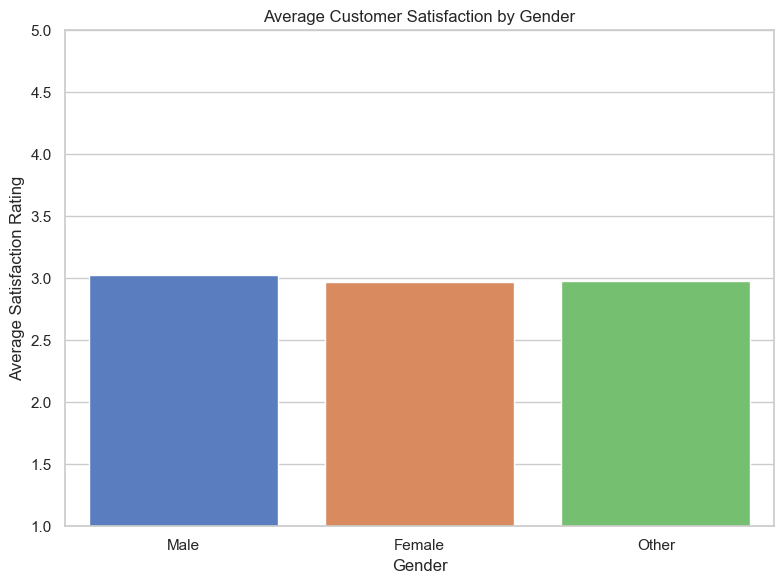

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group and calculate average satisfaction rating by gender
average_satisfaction = df.groupby('customer_gender')['customer_satisfaction_rating'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x='customer_gender',
    y='customer_satisfaction_rating',
    data=average_satisfaction,
    palette='muted',
    order=['Male', 'Female', 'Other']  # Adjust based on actual unique values
)
plt.title('Average Customer Satisfaction by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Satisfaction Rating')
plt.ylim(1, 5)  # Keep the scale consistent
plt.tight_layout()
plt.show()


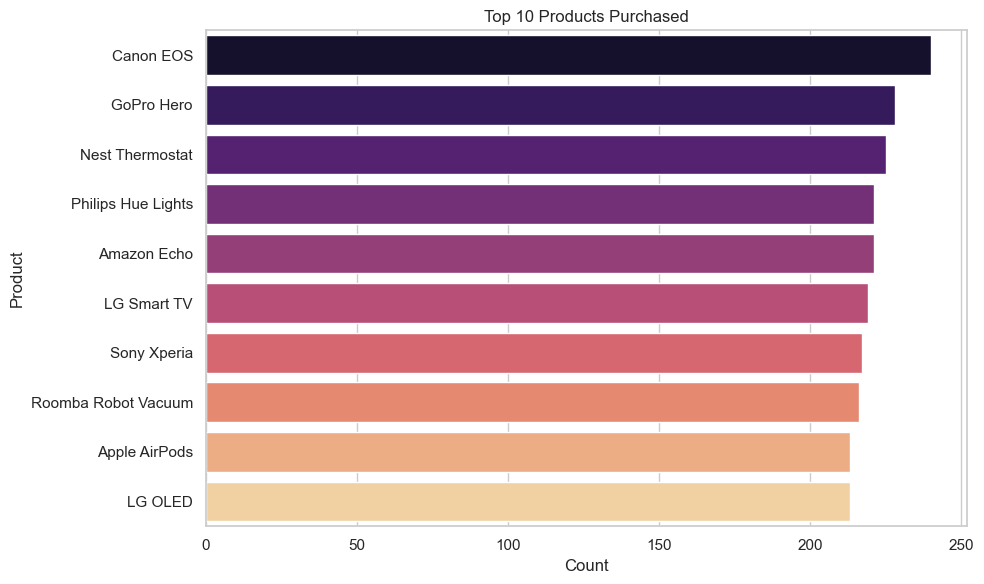

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 10 most purchased products
product_purchased_distribution = df['product_purchased'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    y=product_purchased_distribution.index,
    x=product_purchased_distribution.values,
    palette='magma'
)
plt.title('Top 10 Products Purchased')
plt.xlabel('Count')
plt.ylabel('Product')
plt.tight_layout()
plt.show()


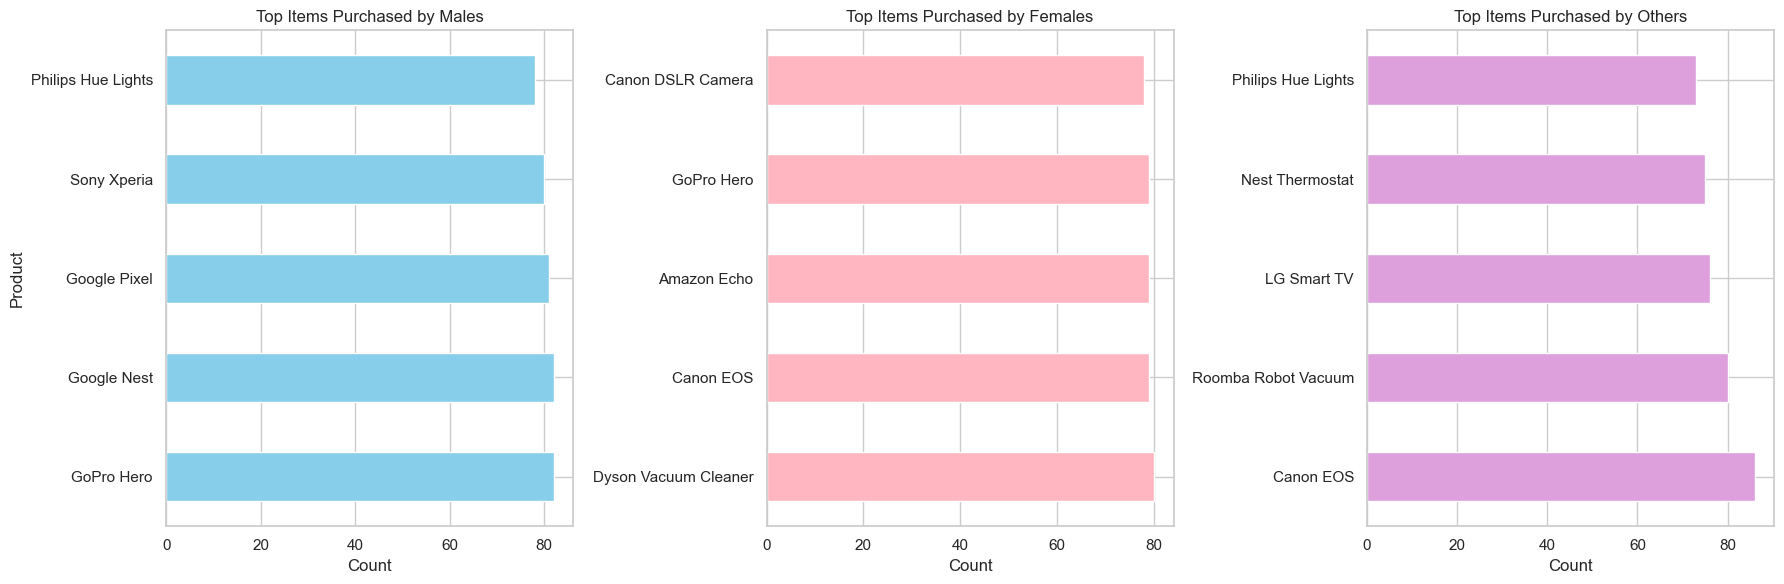

In [223]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# Top Items Purchased by Males
plt.subplot(1, 3, 1)
top_items_male = df[df['customer_gender'] == 'Male']['product_purchased'].value_counts().head(5)
top_items_male.plot(kind='barh', color='skyblue')
plt.title('Top Items Purchased by Males')
plt.xlabel('Count')
plt.ylabel('Product')

# Top Items Purchased by Females
plt.subplot(1, 3, 2)
top_items_female = df[df['customer_gender'] == 'Female']['product_purchased'].value_counts().head(5)
top_items_female.plot(kind='barh', color='lightpink')
plt.title('Top Items Purchased by Females')
plt.xlabel('Count')
plt.ylabel('')

# Top Items Purchased by Others
plt.subplot(1, 3, 3)
top_items_other = df[df['customer_gender'] == 'Other']['product_purchased'].value_counts().head(5)
top_items_other.plot(kind='barh', color='plum')
plt.title('Top Items Purchased by Others')
plt.xlabel('Count')
plt.ylabel('')

plt.tight_layout()
plt.show()


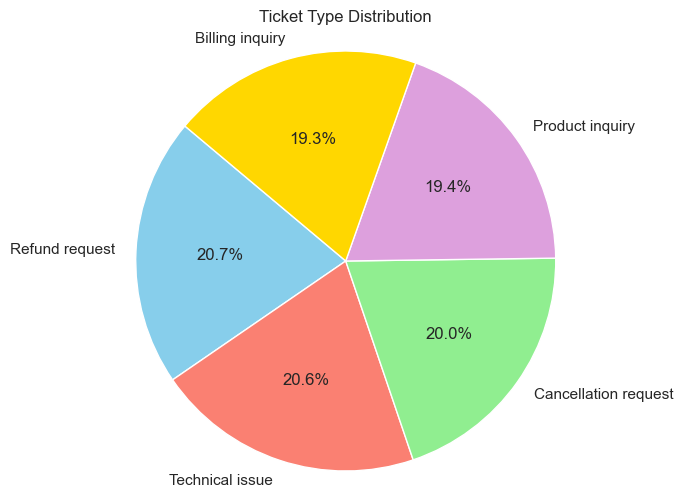

In [225]:
import matplotlib.pyplot as plt

# Count ticket types
ticket_type_distribution = df['ticket_type'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
ticket_type_distribution.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon', 'lightgreen', 'plum', 'gold'],
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Ticket Type Distribution')
plt.ylabel('')
plt.axis('equal')  # Keeps the pie circular
plt.show()


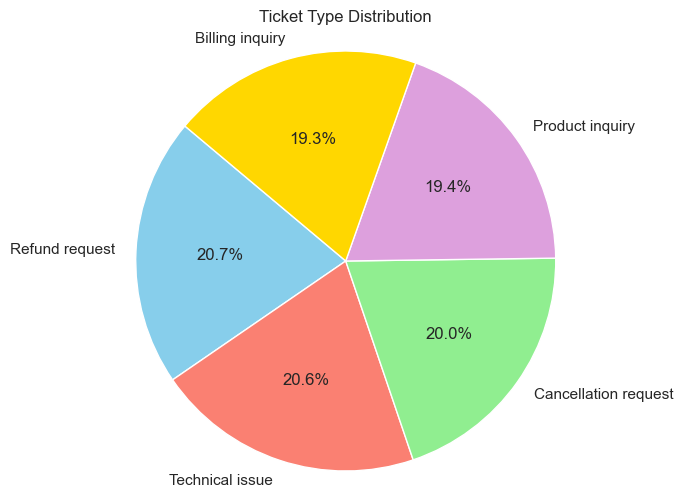

In [233]:
import matplotlib.pyplot as plt

# Count ticket types
ticket_type_distribution = df['ticket_type'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
ticket_type_distribution.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon', 'lightgreen', 'plum', 'gold'],
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Ticket Type Distribution')
plt.ylabel('')
plt.axis('equal')  # Keeps the pie circular
plt.show()


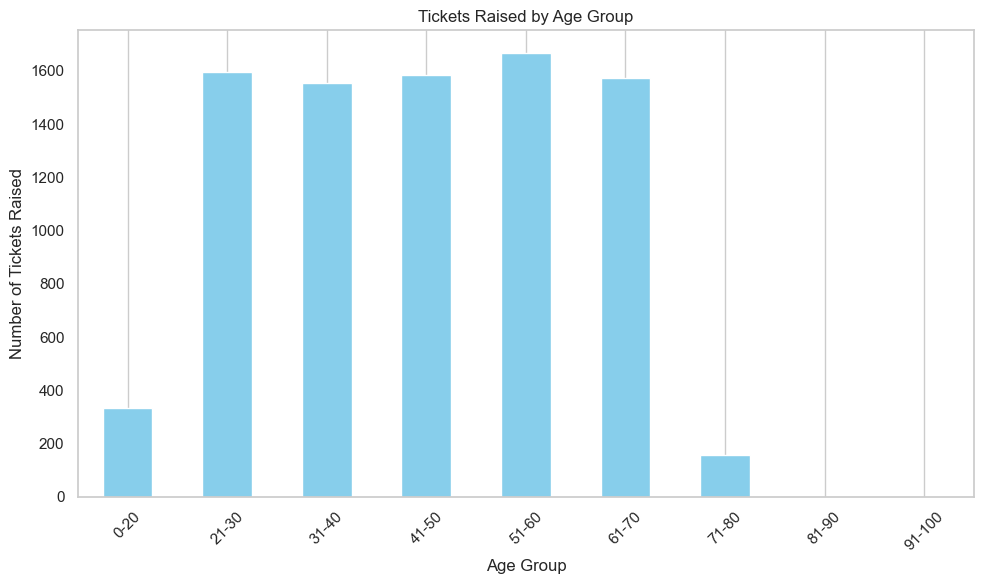

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

# Define age groups
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70',
          '71-80', '81-90', '91-100']

# Categorize customers into age groups
df['age_group'] = pd.cut(df['customer_age'], bins=bins, labels=labels, right=False)

# Calculate number of tickets raised by each age group
tickets_by_age_group = df.groupby('age_group').size()

# Plot
plt.figure(figsize=(10, 6))
tickets_by_age_group.plot(kind='bar', color='skyblue')
plt.title('Tickets Raised by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Tickets Raised')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


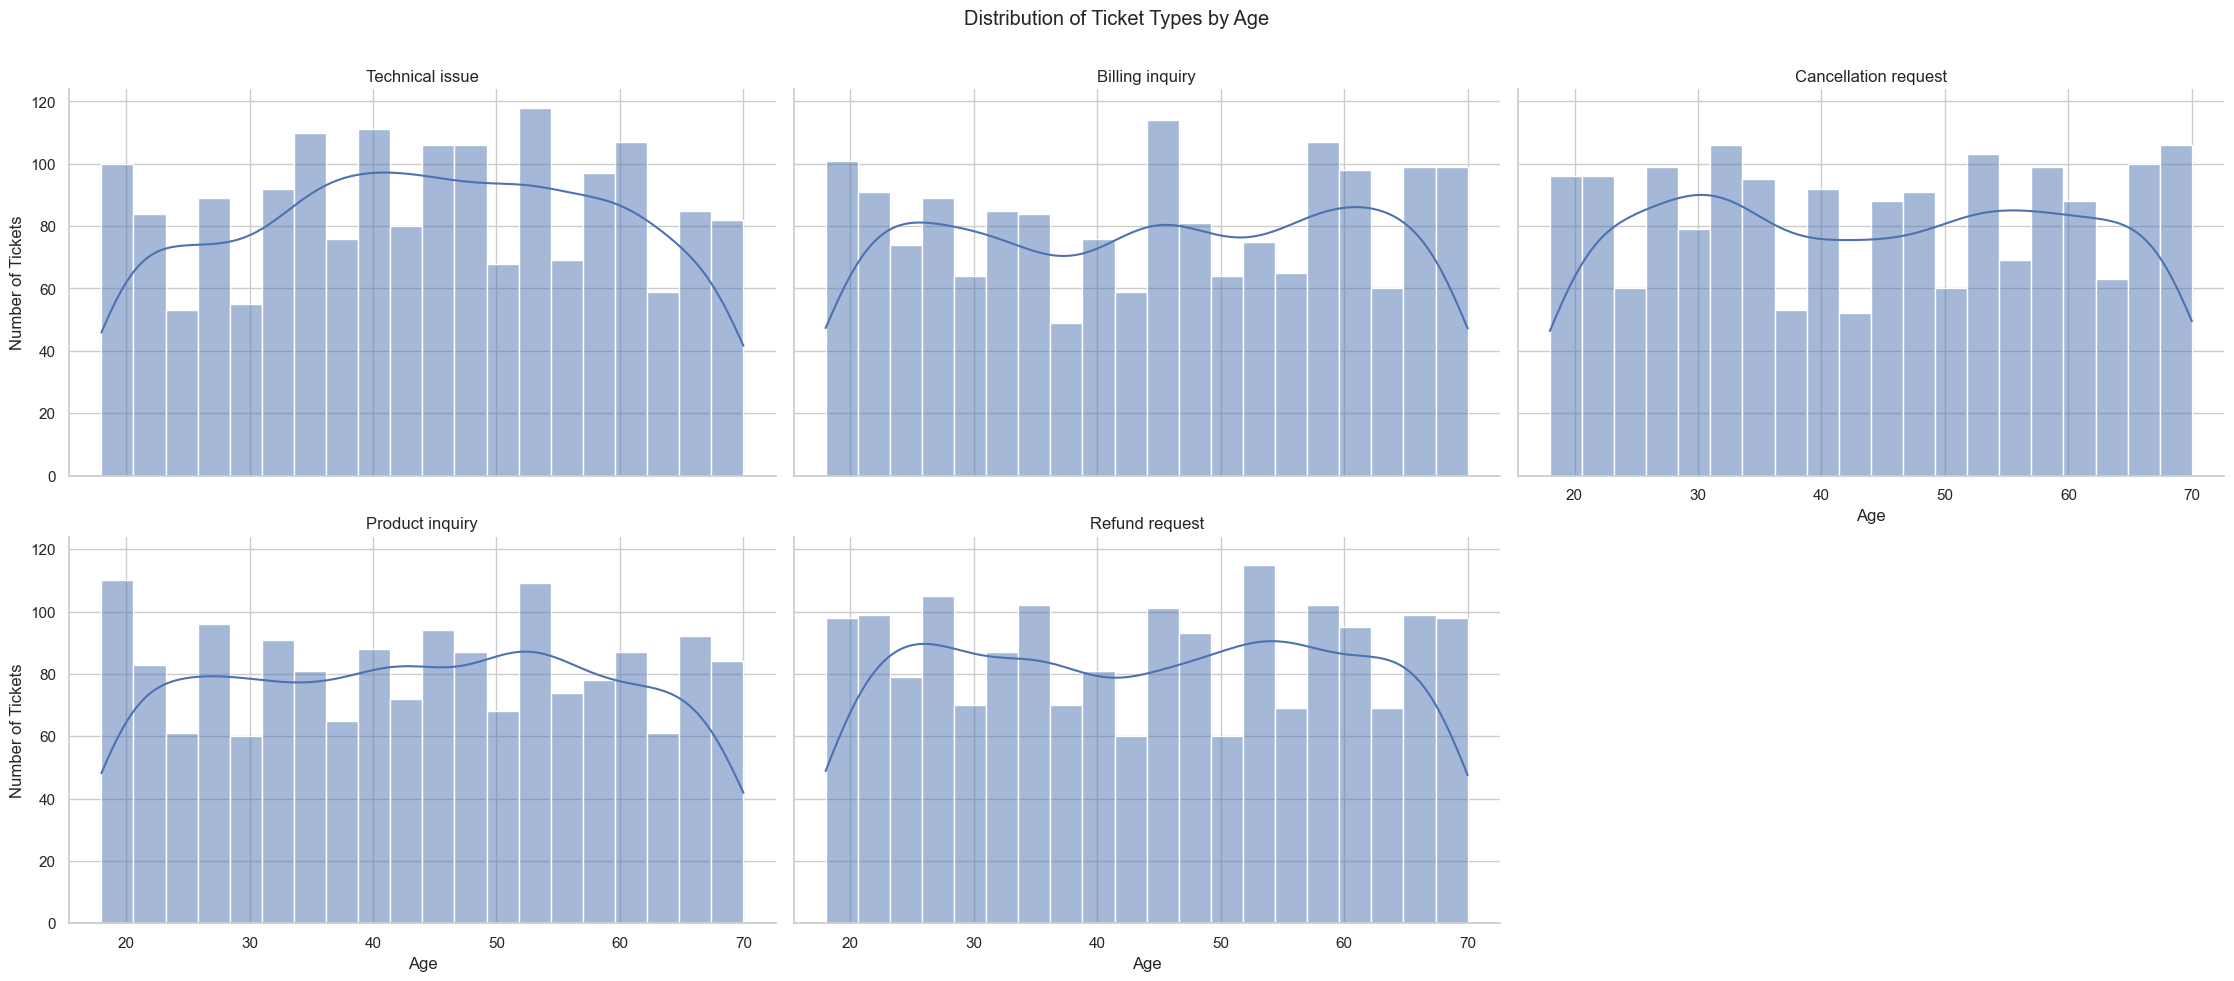

In [237]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create a facet grid for each ticket type
g = sns.FacetGrid(df, col='ticket_type', col_wrap=3, height=5, aspect=1.5)
g.map(sns.histplot, 'customer_age', bins=20, kde=True)

# Set titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Age', 'Number of Tickets')

# Adjust layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Ticket Types by Age')

# Show plot
plt.show()
